# Analyzing Facebook Language used by Anti-Vaccine Pages

In [ ]:
#Basic
import pandas as pd
import numpy as np
import emoji
import math
import os

#NLP
import nltk
from collections import Counter
from itertools import combinations, islice

#Graphics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import wordcloud as wc
from matplotlib.patches import Patch

#ML
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
#Read the data
dtypes = {
    'article_host': 'str', 
    'article_name': 'str', 
    'article_subtitle': 'str', 
    'hashtags': 'object',
    'img-label': 'str', 
    'img_src': 'str', 
    'linked_profiles': 'object', 
    'links': 'object', 
    'text': 'str', 
    'text_tokenized': 'object', 
    'text_tokenized_filtered': 'object',
    'text_tokenized_lemmatized': 'object', 
    'page_name': 'category', 
    'page_name_adjusted': 'category',
    'text_length': 'int32', 
    'wc': 'int32', 
    'sc': 'int32',
    'sixltr': 'int32'
}
posts = pd.read_csv('../input/posts_full.csv', index_col=False, dtype=dtypes, 
                    parse_dates=['timestamp']).drop('Unnamed: 0', axis=1)
posts.head()

### Fix List columns
Columns stored as lists are read back as strings instead of lists

In [ ]:
#Linked_profiles were written as NaN if empty
posts['linked_profiles'] = posts.linked_profiles.fillna('[]')
#Change list columns to lists
list_cols = ['hashtags', 'links', 'linked_profiles', 'text_tokenized', 
             'text_tokenized_filtered', 'text_tokenized_lemmatized']
for col in list_cols:
    posts[col] = posts[col].apply(eval)

### More Features
Add additional features not found in dataset

In [ ]:
#Number of emojis in text
posts['num_emojis'] = posts.text_tokenized.apply(
    lambda x: len([e for e in x if e in emoji.UNICODE_EMOJI]))

#Whether post has an image
posts['has_img'] = ~posts.img_src.isnull()

#Domain from article host
def get_domain(host):
    if type(host) != str:
        return host
    host = host.replace('http://', '').replace('https://', '').split('/')[0]
    if '|' in host:
        host = host.split('|')[0].split('.')[-1].lower()
    elif '.' in host:
        host = host.split('.')[-1].lower()
    else:
        return np.nan
    return host if host.isalpha() else np.nan
posts['article_domain'] = posts.article_host.apply(get_domain).astype('category')

#Fix punc info
puncs = [('periods', '.'), ('exclamations', '!'), ('questionms', '?'), 
         ('equals', '='), ('dollars', '$')]
for name, punc in puncs:
    posts['percent_' + name] = posts.text_tokenized.apply(
        lambda words: words.count(punc)) / posts.num_tokens

#Percent All Caps
posts['percent_all_caps'] = posts.text_tokenized.apply(
    lambda tokens: [token.isupper() for token in tokens].count(True) / 
                    len(tokens) if len(tokens) else 0)

### Data Cleaning

In [ ]:
#Scale 'num_' features by number of words to reduce dependence on how long the text is 
skip_percs = {'num_words', 'num_tokens'}
for nc in [n for n in posts.columns if n.startswith('num_') and n not in skip_percs]:
    percent_column_name = 'percent_' + '_'.join(nc.split('_')[1:])
    if percent_column_name not in posts.columns:
        replacement = (posts[nc] / posts.num_words).apply(
            lambda x: x if not math.isinf(x) else 0)
        posts[percent_column_name] = replacement
    posts.drop(nc, axis=1, inplace=True)

#Take log of positive, exponential columns [text_length, num_words, n]
for c in ['text_length', 'num_words', 'num_tokens']:
    posts[c + '_log'] = pd.Series(np.log(posts[c])).replace([np.inf, -np.inf], 0)
    posts.drop(c, axis=1, inplace=True)

# Data Visualization

In [ ]:
#Improve look of graph by cutting spines and adding opaque grid
def pretty_axis(ax, visible_spines=False, y_grid=True, y_grid_alpha=0.4):
    for g in ax.spines:
        ax.spines[g].set_visible(visible_spines)
    ax.yaxis.grid(y_grid, alpha=y_grid_alpha)

In [ ]:
#Describe the data
posts.describe()

### View Feature Violin Plots

In [ ]:
#Plot numerical data with violin plots
def plot_comparison_violins(df, ncols=3, figsize=None, filename='Violin Comparisons.png', ax_mod=None):
    num = df.select_dtypes(['float64', 'int64', 'int16']).fillna(0)
    num['anti_vax'] = df.anti_vax.apply(
        lambda x: 'Anti-Vax' if x else 'Normal').astype('category')
    nrows = int(np.ceil(len(num.columns[:-1]) / ncols))
    blank = np.zeros(num.shape[0])
    if not figsize:
        figsize=(21, 6 * nrows)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for i, col in enumerate(num.columns[:-1]):
        ax = None
        if ncols * nrows == 1:
            ax = axes
        elif nrows == 1:
            ax = axes[i % ncols]
        else:
            ax = axes[int(i / ncols), i % ncols]
        sns.violinplot(x=blank, y=col, hue='anti_vax', data=num, 
                       split=True, ax=ax, orient='v', legend=False)
        ax.xaxis.set_visible(False)
        ax.legend()
        ax.set_title(col)
        ax.set_ylabel('')
        pretty_axis(ax, y_grid_alpha=0.3)
        if ax_mod:
            ax_mod(ax)
    for i in range(len(num.columns) - 1, nrows * ncols):
        fig.delaxes(axes[int(i / ncols), i % ncols])
    fig.tight_layout()
    fig.savefig(filename, bbox_inches='tight')
plot_comparison_violins(posts[[c for c in posts.columns if 
                               c.startswith('percent_') or c == 'anti_vax'][:12]])

## Stylistic Features

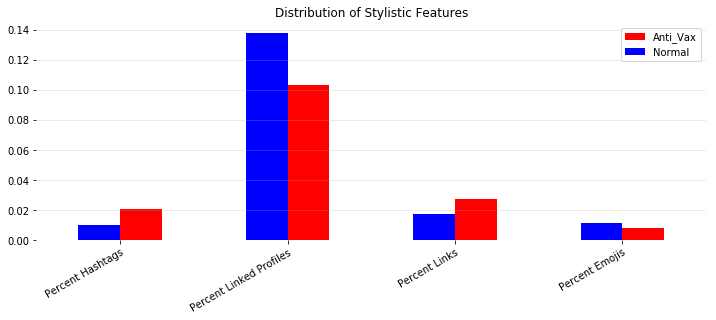

In [106]:
stylistic_columns = ['percent_hashtags', 'percent_linked_profiles', 
                     'percent_links', 'percent_emojis', 'anti_vax']
ax = posts[stylistic_columns].groupby('anti_vax').mean().transpose().plot(
    kind='bar', color=['b', 'r'], figsize=(12, 4))
pretty_axis(ax, y_grid_alpha=0.3)
ax.set_title('Distribution of Stylistic Features')
ax.legend(handles=[Patch(facecolor='red', label='Anti_Vax'), 
                   Patch(facecolor='blue', label='Normal')])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha="right", rotation_mode="anchor")
ax.set_xticklabels(['Percent Hashtags', 'Percent Linked Profiles', 'Percent Links', 'Percent Emojis']);

In [60]:
#Scale numerical data normally
numerical_columns = posts.select_dtypes(['float64', 'float32', 
                                         'int64', 'int32', 'int16']).columns
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(posts[numerical_columns].fillna(0)), 
                               columns=numerical_columns)
scaled_features = scaled_features.join(
    posts.select_dtypes(['bool'])).drop('anti_vax', axis=1)
scaled_features.head()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,percent_periods,percent_exclamations,percent_questionms,percent_equals,percent_dollars,ttr,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,readability_smog_index,readability_gunning_fog,readability_flesch_kincaid_grade,wc,sc,wps,dic,sixltr,funct,pronoun,ppron,i,we,you,shehe,they,ipron,article,verbs,auxvb,past,present,future,adverbs,prep,conj,negate,quant,numbers,swear,...,percent_pos_VBG,percent_pos_PRP$,percent_pos_JJ,percent_pos_PRP,percent_pos_TO,percent_pos_POS,percent_pos_VBP,percent_pos_WRB,percent_pos_JJR,percent_pos_IN,percent_pos_SYM,percent_pos_WP,percent_pos_NNP,percent_pos_EX,percent_pos_LS,percent_pos_FW,percent_pos_NNPS,percent_pos_CD,percent_pos_VBN,percent_pos_PDT,percent_pos_RP,percent_pos_NN,percent_pos_WDT,percent_pos_VBD,percent_pos_RBS,percent_pos_UH,percent_pos_VB,percent_pos_RB,percent_pos_MD,percent_pos_JJS,percent_pos_'',percent_pos_WP$,percent_pos_VBZ,percent_emojis,text_length_log,num_words_log,num_tokens_log,has_article,has_text,has_img
0,0.038537,-0.330169,0.623447,-0.025075,-0.049134,0.320742,0.536715,0.707525,-0.742552,-1.342403,-0.524824,0.240727,0.077457,-0.155835,-0.186541,0.710968,0.553597,-0.235455,0.585216,1.251786,1.256643,-0.265118,1.951041,0.877466,0.393361,1.336900,1.087277,1.027857,1.387067,1.333933,0.651196,1.481000,2.177826,1.405529,-0.329560,0.375854,0.993217,0.054001,-0.146642,-0.080316,...,-0.138106,-0.170696,-0.056024,-0.288291,-0.107506,-0.007178,-0.695574,-0.165317,-0.126698,-0.444332,-0.009079,-0.13512,-0.075238,-0.065088,-0.003336,4.216957,-0.009217,-0.454292,-0.200374,-0.03223,-0.082163,1.048721,-0.060365,-0.328583,-0.059201,-0.033112,0.329203,-0.538962,-0.232688,-0.123571,-0.00879,-0.037375,-0.260901,-0.115496,0.375809,0.258030,0.380439,True,True,True
1,-0.620940,-0.330169,-0.275671,-0.025075,-0.049134,0.682785,-0.529333,1.023221,-0.742552,-0.316669,-0.524824,0.319617,0.314652,-0.302239,-0.277774,0.122254,-0.204676,-0.205544,-0.347981,0.352972,1.178269,-0.265118,-0.376536,0.819659,2.152232,1.266446,-0.039456,0.963769,-0.318193,0.265454,-0.266972,0.073552,0.140451,1.049436,0.608210,-0.051793,0.148381,0.621579,2.786748,1.049256,...,-0.138106,-0.170696,-0.239913,-0.288291,-0.107506,-0.007178,-0.695574,-0.165317,-0.126698,-0.444332,-0.009079,-0.13512,-0.075238,-0.065088,-0.003336,-0.099518,-0.009217,-0.454292,-0.200374,-0.03223,-0.082163,1.048721,-0.060365,-0.328583,-0.059201,-0.033112,-0.529239,-0.538962,-0.232688,-0.123571,-0.00879,-0.037375,5.243196,-0.115496,0.068098,-0.073790,-0.295164,True,True,True
2,-0.620940,-0.330169,-0.275671,-0.025075,-0.049134,0.165581,-0.025922,0.874142,-0.742552,-0.467014,-0.524824,0.830079,0.773229,-0.186657,-0.277774,2.084635,-0.783357,-0.115809,-0.605721,-0.624487,-1.094577,-0.265118,-0.376536,-0.856740,-0.532360,-0.776740,-0.250264,-0.894786,-1.178237,-1.210064,-0.782331,-1.243093,-1.018057,-0.698157,-0.168800,-0.728252,-0.551626,-0.475738,0.660041,-0.674828,...,-0.138106,-0.170696,-0.371262,-0.288291,-0.107506,-0.007178,1.516603,-0.165317,-0.126698,-0.444332,-0.009079,-0.13512,-0.075238,-0.065088,-0.003336,-0.099518,-0.009217,-0.454292,-0.200374,-0.03223,-0.082163,1.236922,-0.060365,-0.328583,-0.059201,-0.033112,-0.529239,-0.538962,-0.232688,-0.123571,-0.00879,-0.037375,-0.260901,-0.115496,0.443372,0.476595,0.432489,True,True,False
3,-0.000256,0.228328,-0.275671,-0.025075,-0.049134,0.036279,-0.529333,1.023221,-0.742552,-0.316669,-0.524824,-0.399671,0.172335,-0.163541,-0.186541,0.645555,-0.287344,-0.085897,0.050903,-0.694305,-0.688711,-0.265118,-0.376536,-0.258026,-0.532360,-0.047031,-0.340611,-0.231017,-0.433378,-0.156122,-0.819142,-0.302633,-0.190551,0.935956,0.400082,-0.373916,-0.601626,0.425630,1.141082,-0.674828,...,-0.138106,-0.170696,0.810880,-0.288291,-0.107506,-0.007178,-0.695574,-0.165317,-0.126698,-0.444332,-0.009079,-0.13512,-0.075238,-0.065088,-0.003336,-0.099518,-0.009217,1.081755,-0.200374,-0.03223,-0.082163,0.295919,-0.060365,3.140075,-0.059201,-0.033112,-0.529239,0.115714,-0.232688,-0.123571,-0.00879,-0.037375,-

 ## PCA on 2 Components (No Encodings)

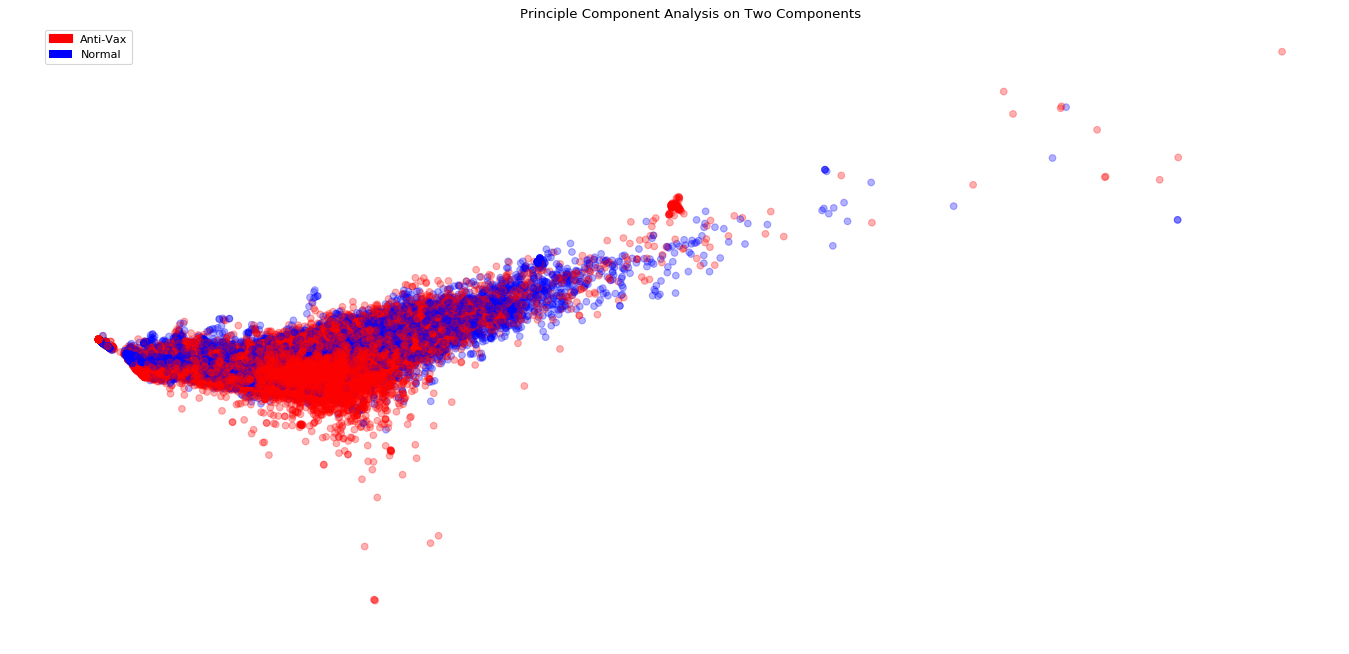

In [72]:
#Run PCA-2 on scaled data for plotting
pca = PCA(n_components=2)
decomposed = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(decomposed, columns=['x', 'y'])
pca_df['anti_vax'] = posts.anti_vax.apply(
    lambda x: 'Anti-vax' if x else 'Normal').astype('category')

#Plot PCA
plt.figure(figsize=(21, 10), dpi=80)
path = plt.scatter(pca_df.x, pca_df.y, alpha=0.3, cmap='bwr',
                   c=pca_df.anti_vax.apply(lambda x: 'red' if 
                                           x == 'Anti-vax' else 'blue'))
path.axes.set_title('Principle Component Analysis on Two Components');
plt.legend(handles=[Patch(facecolor='red', edgecolor='r', label='Anti-Vax'), 
                    Patch(facecolor='blue', label='Normal')])
for g in path.axes.spines:
    path.axes.spines[g].set_visible(False)
plt.axis('off')
plt.savefig('PCA.png', bbox_inches='tight')

### Correlation Heatmap - No Features Removed

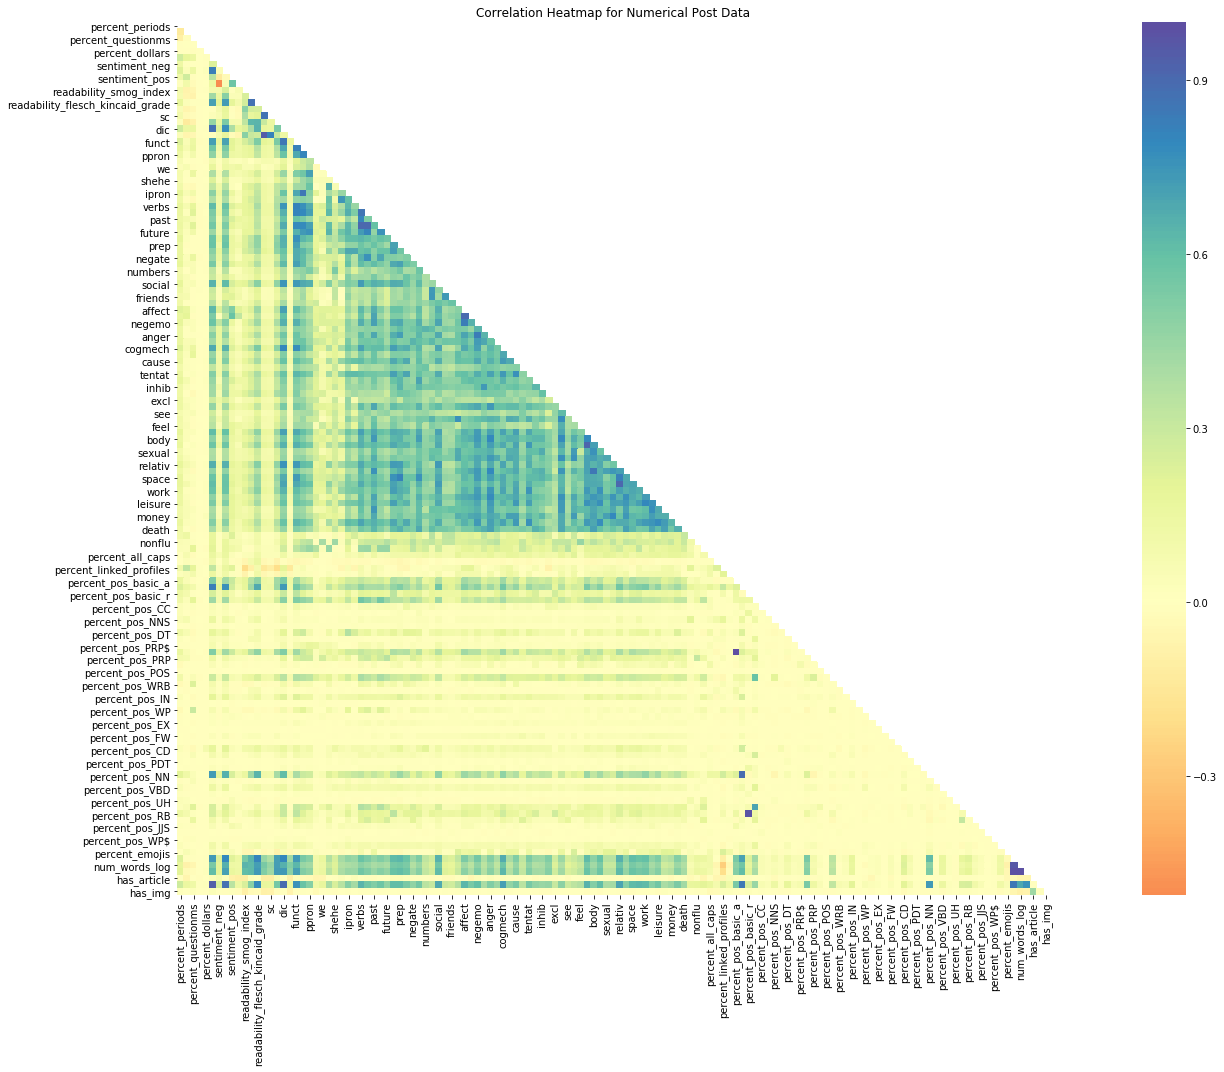

In [108]:
corr = scaled_features.corr()
fig, ax = plt.subplots(figsize=(26, 15))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, ax=ax, cmap='Spectral', 
            square=True, center=0.0)
ax.set_title('Correlation Heatmap for Numerical Post Data')
fig.tight_layout()
fig.savefig('Correlation Heatmap.png', bbox_inches='tight');

## Feature Correlation with Anti-Vax (No Encodings)

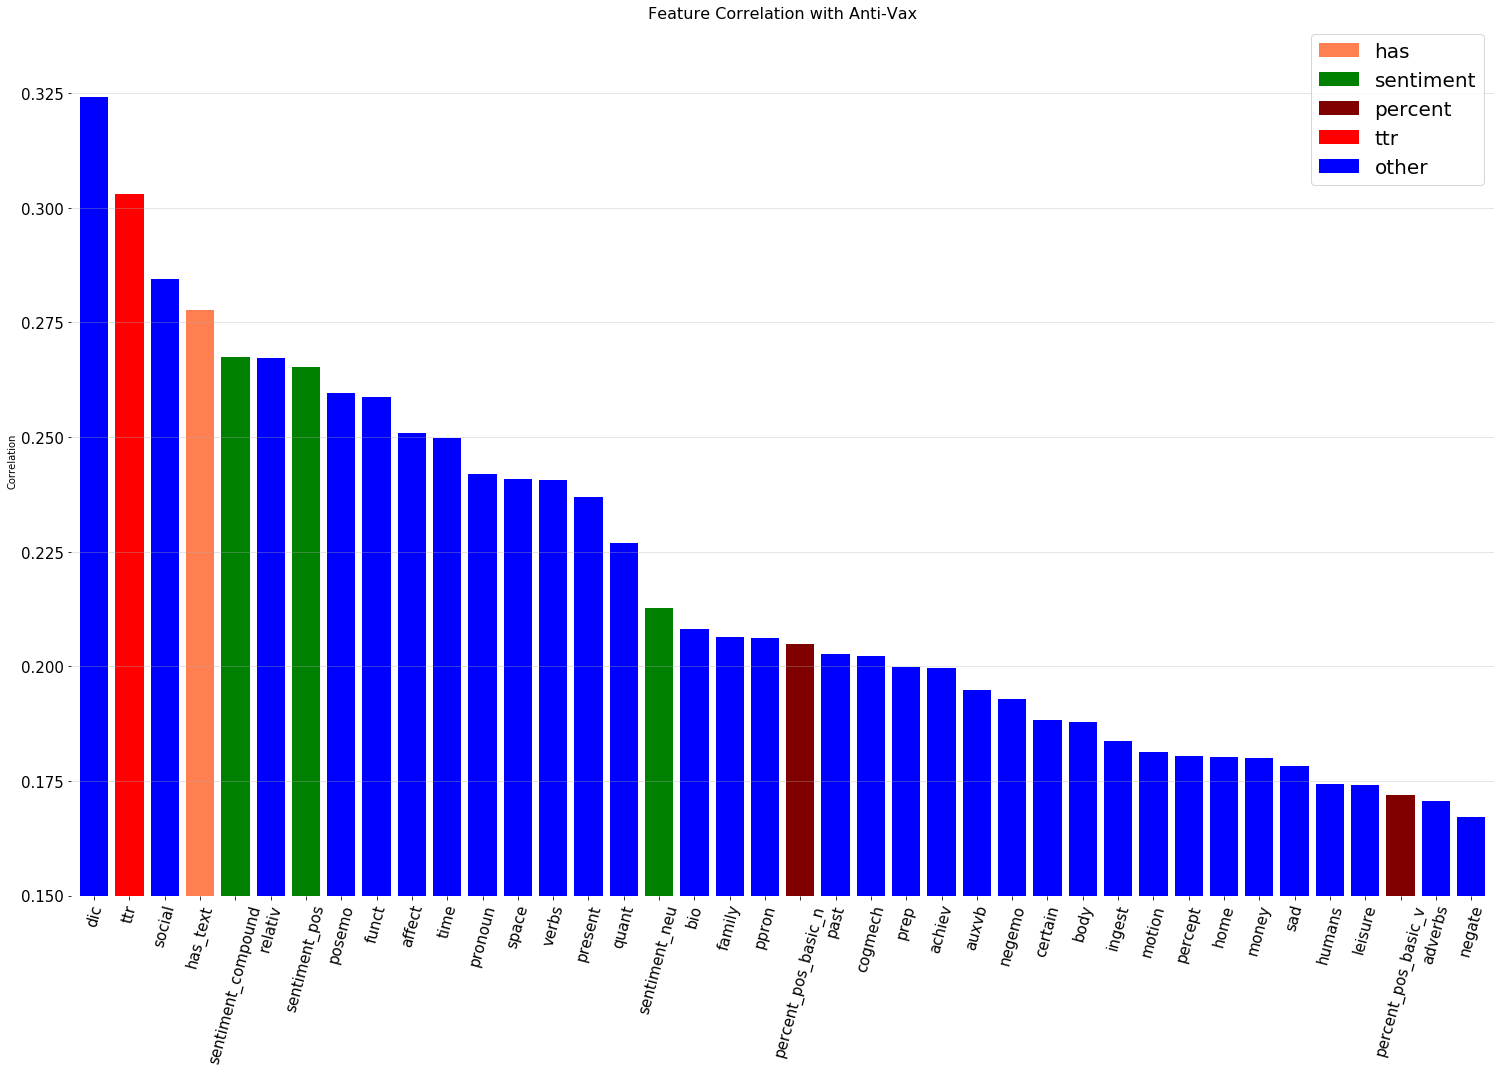

In [74]:
#Show correlation with Anti-Vax
feature_corr = scaled_features.corrwith(posts.anti_vax).abs(
                    ).sort_values(ascending=False).head(40)

#Generate colors for the bars based upon where the features came from
color_categories = {'text_': 'black', 'num_pos': 'orange', 'num_': 'yellow', 
                    'ttr': 'red', 'sentiment_': 'green', 
                    'percent_': 'maroon', 'readability_': 'lightgreen', 
                    'has_': 'coral', 'other': 'blue'}
def generate_categories(col):
    for cc in color_categories:
        if col.startswith(cc):
            return cc
    return 'other'
column_cats = [generate_categories(c) for c in feature_corr.index]
column_colors = [color_categories[c] for c in column_cats]

#Legend for the plot
handles = []
for c in set(column_cats):
    handles.append(Patch(facecolor=color_categories[c], 
                         label=c.replace('_', '')))

fig, ax = plt.subplots(figsize=(21, 15))
feature_corr.plot.bar(ax=ax, width=0.8, rot=75, color=column_colors)
ax.set_ylim((0.15, 0.34))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Feature Correlation with Anti-Vax', fontsize=16)
ax.set_ylabel('Correlation')
pretty_axis(ax)
ax.legend(handles=handles, prop={'size': 20})
fig.tight_layout()
fig.savefig('Feature Correlation.png', bbox_inches='tight');

## Distribution of Strongest Feature

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


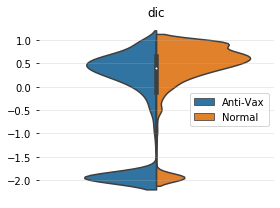

In [114]:
plot_comparison_violins(scaled_features[[feature_corr.index[0]]].join(posts.anti_vax), 
                        ncols=1, filename=feature_corr.index[0] + ' Comparison.png', 
                        figsize=(4, 3), ax_mod=lambda ax: ax.legend(loc='center right'))

## Feature Variance Analysis

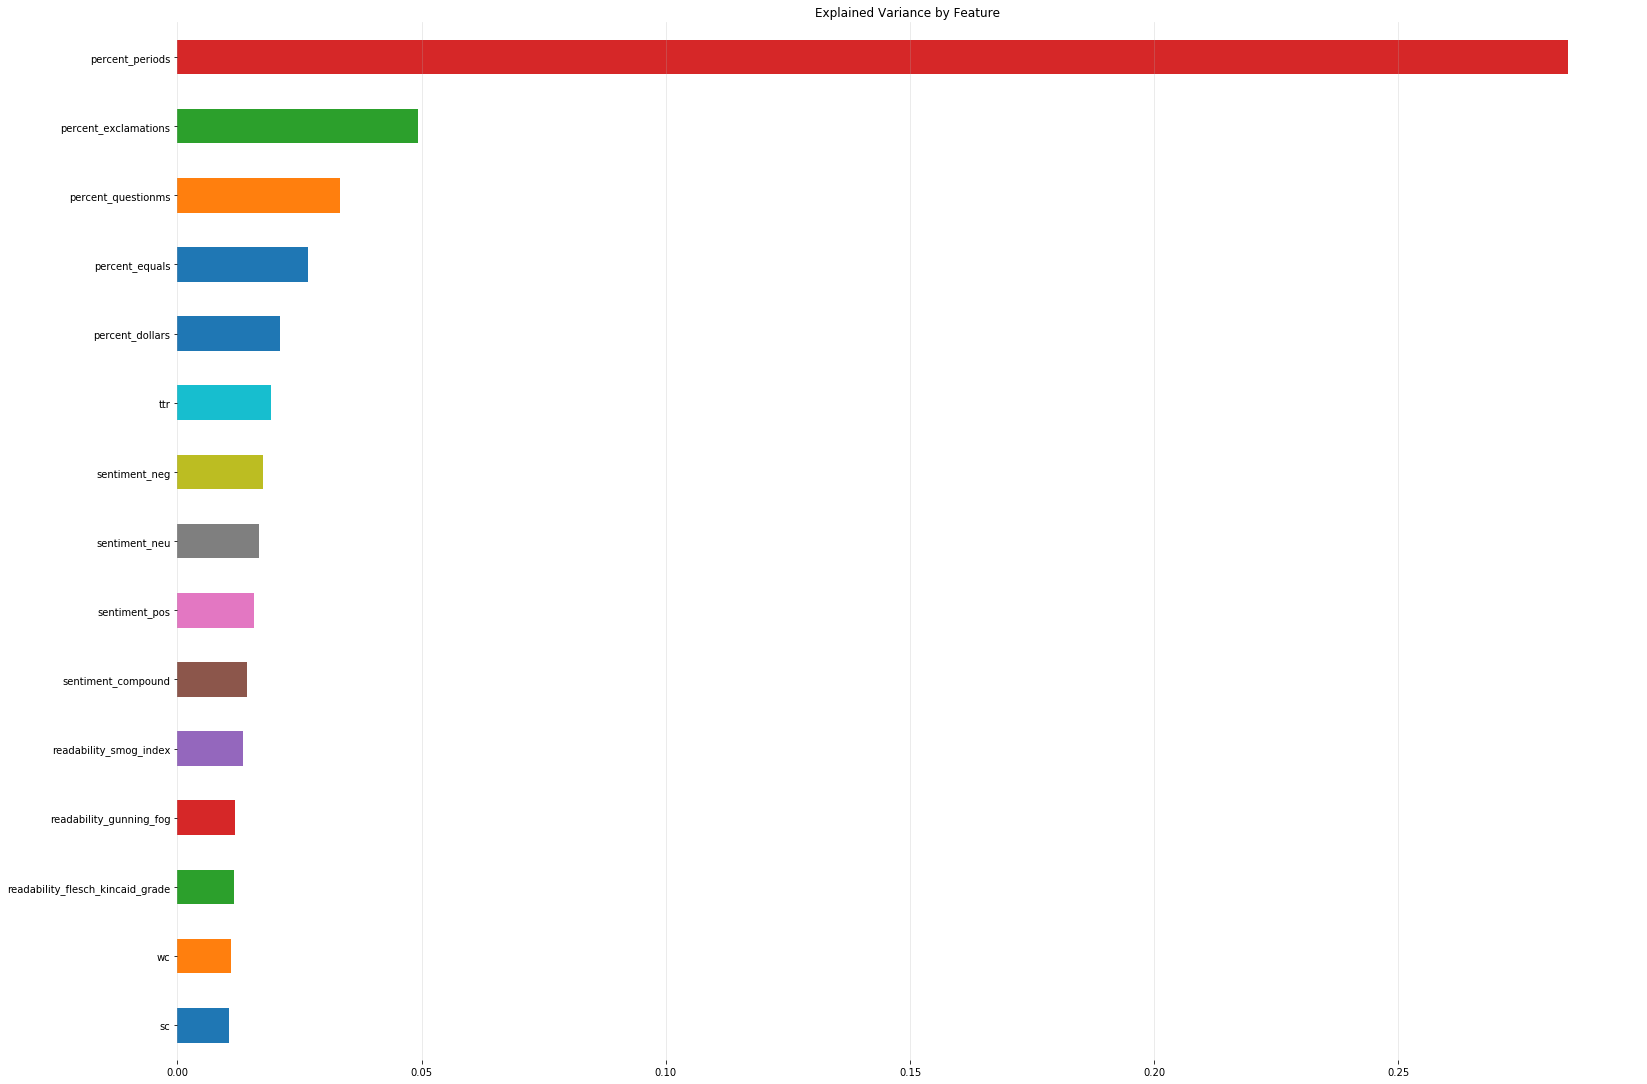

In [76]:
cov_pca = PCA(n_components=len(scaled_features.columns))
cov_pca.fit(scaled_features)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
explained_var = pd.Series(cov_pca.explained_variance_ratio_, 
                          index=scaled_features.columns).sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(21, 15))
fig.tight_layout()
ax = explained_var[explained_var > 0.01].plot.barh(ax=ax)
ax.set_title('Explained Variance by Feature')
pretty_axis(ax, y_grid=False)
ax.xaxis.grid(True, alpha=0.3)
ax.yaxis.grid(False)
fig.savefig('Explained Variance.png', bbox_inches='tight');

## Distribution of Domain Usage

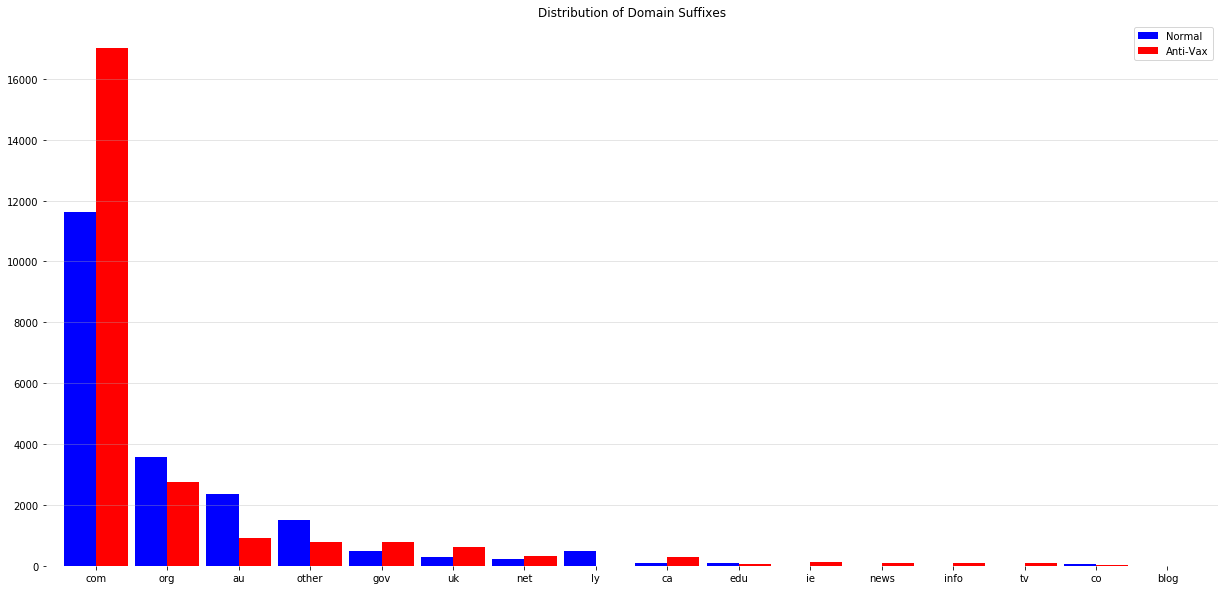

In [122]:
observing_domains = {'au', 'com', 'ca', 'gov', 'edu', 'net', 'blog', 
                     'org', 'ly', 'uk', 'news', 'ie', 'info', 'tv', 'co'}
domain_posts = posts.loc[~posts.article_domain.isnull(), 
                         ['anti_vax', 'article_domain']]
domain_posts['article_domain'] = domain_posts.article_domain.apply(
    lambda x: x if x in observing_domains else 'other').astype('category')

#Graph the domains
fig, ax = plt.subplots(figsize=(21, 10))
domain_posts = domain_posts.groupby(['anti_vax']).article_domain.value_counts(
                                            ).unstack(fill_value=0).transpose()
domain_posts['sum'] = domain_posts[True] + domain_posts[False]
domain_posts = domain_posts.sort_values(by='sum', 
                                        ascending=False).drop('sum', axis=1)
domain_posts.plot(kind='bar', ax=ax, stacked=False, 
                  color=['blue', 'red'], width=0.9, rot=0)
pretty_axis(ax)
ax.set_xlabel('')
ax.legend(handles=[Patch(facecolor='blue', label='Normal'), 
                   Patch(facecolor='red', label='Anti-Vax')])
ax.set_title('Distribution of Domain Suffixes')
fig.savefig('Domain Distribution.png', bbox_inches='tight')

## Bigram Analysis

In [78]:
#Get bigrams of a group posts
stop_words = set(nltk.corpus.stopwords.words("english")).union(
    wc.STOPWORDS).union(observing_domains).union({'http', 'https'})
def bigrams(posts, most_common=20):
    w = posts.text_tokenized_lemmatized.apply(
        lambda words: [word for word in words if word not in stop_words and not word.isdigit()])
    def count_bigrams(words):
        return Counter(zip(words, islice(words, 1, None)))
    return w.apply(count_bigrams).sum().most_common(most_common)
sample_size, most_common = 3000, 50
anti_vax_bigrams = bigrams(posts[posts.anti_vax].sample(n=sample_size), 
                           most_common=most_common)
normal_bigrams = bigrams(posts[~posts.anti_vax].sample(n=sample_size), 
                         most_common=most_common)

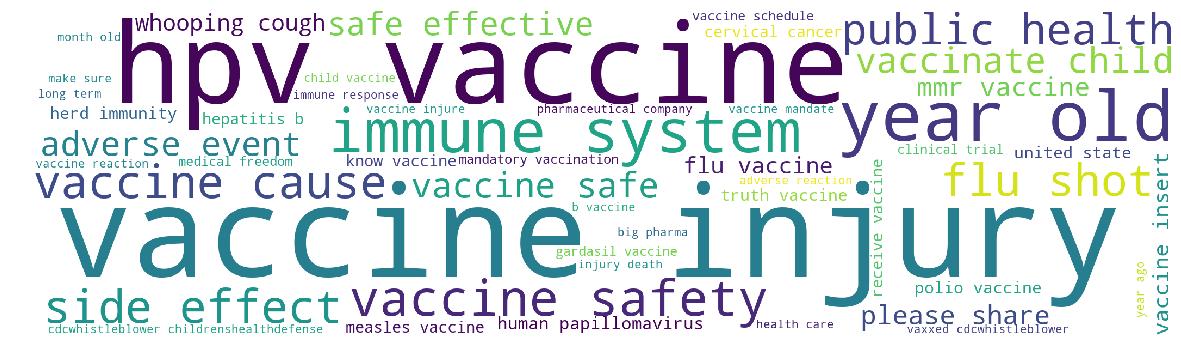

In [79]:
#Show Anti_Vax Bigrams
wordcloud = wc.WordCloud(stopwords=stop_words, background_color='white', 
                         width=2100, height=600).fit_words({' '.join(couple): count for 
                                                            couple, count in anti_vax_bigrams})
fig = plt.figure(figsize=(21, 6))
plt.imshow(wordcloud)
plt.axis('off')
fig.savefig('Anti-Vax Bigram Wordcloud.png', bbox_inches='tight')
plt.show()

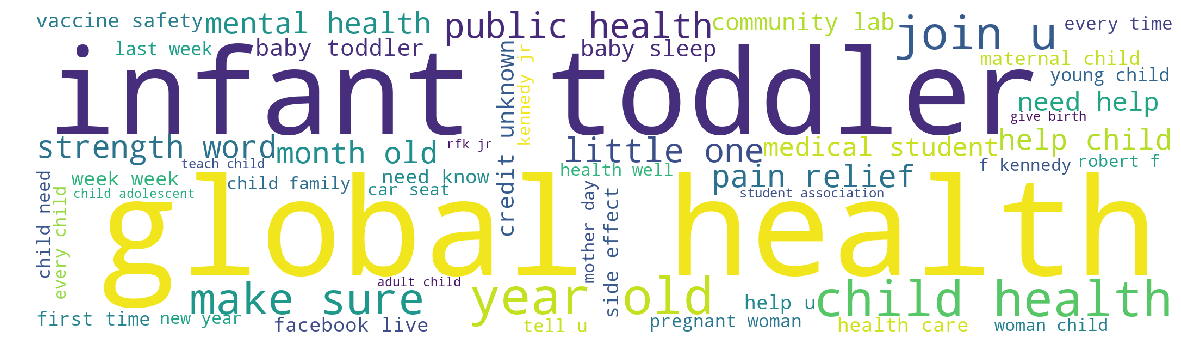

In [80]:
#Show Normal Bigrams
wordcloud = wc.WordCloud(stopwords=stop_words, background_color='white', 
                         width=2100, height=600).fit_words({' '.join(couple): count for 
                                                            couple, count in normal_bigrams})
fig = plt.figure(figsize=(21, 6))
plt.imshow(wordcloud)
plt.axis('off')
fig.savefig('Normal Bigram Wordcloud.png', bbox_inches='tight')
plt.show()

## Pair Analysis

In [81]:
#Get pairs for a group of posts
def pairs(posts, most_common=20):
    w = posts.text_tokenized_lemmatized.apply(
        lambda words: [word for word in words if 
                       word not in stop_words and not word.isdigit()])
    def pairs(words):
        return list(combinations(set(words), 2))
    counter = Counter()
    for ind, val in w.apply(pairs).iteritems():
        counter.update(val)
    return counter.most_common(most_common)
sample_size = 30000
anti_vax_pairs = pairs(posts[posts.anti_vax].sample(n=sample_size), most_common=None)
normal_pairs = pairs(posts[~posts.anti_vax].sample(n=sample_size), most_common=None)

In [82]:
#Clean pairs and convert to a dataframe
pairs = {}
for anti in anti_vax_pairs:
    a, b = anti[0]
    if b < a:
        a, b = b, a
    pairs[(a, b)] = [anti[1], 0]
for norm in normal_pairs:
    a, b = norm[0]
    if b < a:
        a, b = b, a
    if (a, b) not in pairs:
        pairs[(a, b)] = [0, 0]
    pairs[(a, b)] = [pairs[(a, b)][0], norm[1]]
pairs = pd.DataFrame([(pair, count[0], count[1]) for pair, count in pairs.items()], columns=['Pair', 'Anti-Vax Count', 'Normal Count'])
pairs['Difference'] = pairs['Anti-Vax Count'] - pairs['Normal Count']
pairs['Abs_Difference'] = pairs.Difference.abs()
pairs.set_index('Pair', inplace=True)
pairs.head()

,Anti-Vax Count,Normal Count,Difference,Abs_Difference
Pair,,,,
"(child, vaccine)",362,57,305,305
"(know, vaccine)",111,94,17,17
"(vaccination, vaccine)",165,15,150,150
"(one, vaccine)",157,17,140,140
"(make, vaccine)",115,33,82,82


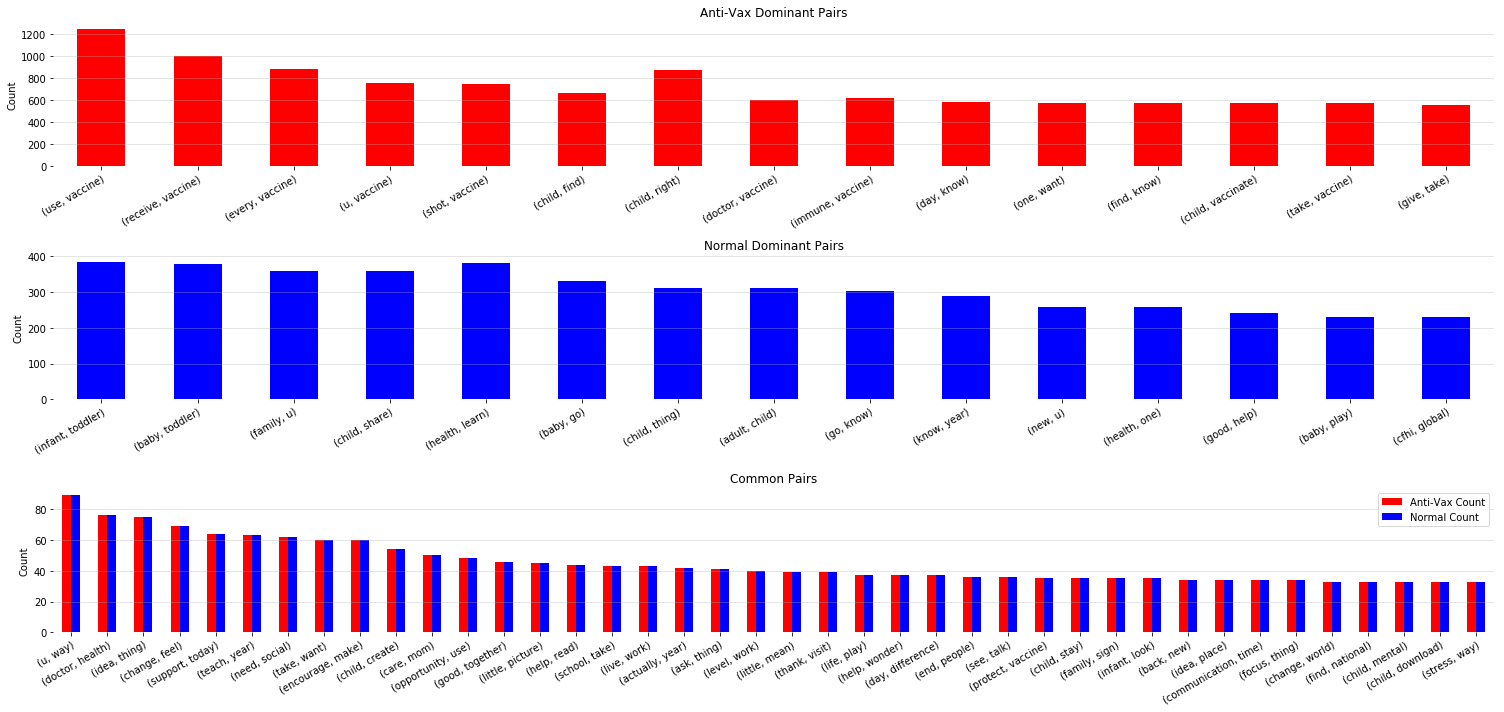

In [83]:
#View Anti-Vax heavy pairs
fig, axes = plt.subplots(3, 1, figsize=(21, 10))
pair_plots = {
    'Anti-Vax Dominant Pairs': pairs.sort_values(['Difference', 'Anti-Vax Count'], 
                                                 ascending=False).iloc[:15, 0], 
    'Normal Dominant Pairs': pairs.sort_values(['Difference', 'Normal Count'], 
                                               ascending=[True, False]).iloc[:15, 1],
    'Common Pairs': pairs[(pairs['Anti-Vax Count'] != 0) & 
                          (pairs['Normal Count'] != 0)].sort_values(['Abs_Difference', 
                                                                     'Normal Count'], 
                                                                    ascending=[True, False]).iloc[:40, :2]
}
for i, ((title, data), color) in enumerate(zip(pair_plots.items(), ['r', 'b', ['r', 'b']])):
    data.plot(kind='bar', ax=axes[i], color=color)
    pretty_axis(axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=30, ha="right", 
             rotation_mode="anchor") 
fig.tight_layout()
fig.savefig('Pairs Comparison.png', bbox_inches='tight');

# Determine Significant Scores through Independence t-Tests

In [84]:
from scipy.stats import ttest_ind
def test_significant_scores(df):
    anti_vax, normal = df[df.anti_vax], df[~df.anti_vax]
    data = pd.DataFrame({'Feature': df.columns})
    data['t_value'] = data.Feature.apply(lambda f: ttest_ind(anti_vax[f], normal[f], equal_var=False))
    data['p_value'] = data.t_value.apply(lambda x: x[1])
    data['t_value'] = data.t_value.apply(lambda x: x[0])
    return data
feature_tests = test_significant_scores(scaled_features.join(posts.anti_vax))
feature_tests['Significant'] = feature_tests.p_value <= 0.05
feature_tests.set_index('Feature', inplace=True)
feature_tests.to_csv('Significance.csv')
feature_tests.head()

,t_value,p_value,Significant
Feature,,,
percent_periods,-26.71428,0.00000,True
percent_exclamations,-28.60266,0.00000,True
percent_questionms,-22.00374,0.00000,True
percent_equals,-1.43055,0.15256,False
percent_dollars,3.74736,0.00018,True


In [85]:
feature_tests[feature_tests.p_value > 0.05].sort_values(by='p_value', ascending=False)

,t_value,p_value,Significant
Feature,,,
percent_pos_SYM,-0.22906,0.81882,False
percent_pos_POS,-0.80972,0.41811,False
percent_pos_LS,-1.00000,0.31732,False
percent_pos_WP$,1.39105,0.16421,False
percent_equals,-1.43055,0.15256,False
percent_pos_$,-1.51733,0.12919,False
percent_pos_NNPS,-1.55756,0.11934,False
percent_pos_EX,-1.79127,0.07325,False
percent_pos_'',-1.89441,0.05818,False


In [86]:
feature_tests[feature_tests.p_value <= 0.05].sort_values(by='t_value', ascending=True).head()

,t_value,p_value,Significant
Feature,,,
dic,-104.46158,0.00000,True
ttr,-97.30147,0.00000,True
social,-89.22629,0.00000,True
has_text,-88.85705,0.00000,True
sentiment_compound,-83.45398,0.00000,True


# Compile All Features (Future Work)

In [ ]:
#Add categorical dummy variables for which hashtags were in the text
#hashtags = set(posts.hashtags.sum())
#for hashtag in hashtags:
#    scaled_features['hashtag_' + hashtag] = posts.hashtags.apply(lambda x: hashtag in x)
#Add categorical dummy variables for the domain of the article linked
#scaled_features = scaled_features.join(pd.get_dummies(posts.article_domain))
#TODO: Add Bigram dummies